In [1]:
import torch
import torch.nn.functional as F
import random
import math
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X_ = np.array(X)
    Y_ = np.array(Y)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X, Y, X_, Y_

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr, Xtr_, Ytr_= build_dataset(words[:n1])     # 80%
Xdev, Ydev, Xdev_, Ydev_ = build_dataset(words[n1:n2])   # 10%
Xte,  Yte, Xte_, Yte_ = build_dataset(words[n2:])     # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [12]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [17]:
# MLP 

C_  = np.random.randn(vocab_size, n_embd)
W1_ = np.random.randn(n_embd * block_size, n_hidden)
b1_ = np.random.randn(n_hidden)
W2_ = np.random.randn(n_hidden, vocab_size)
b2_ = np.random.randn(vocab_size)


parameters_= [C_, W1_, b1_, W2_, b2_]

print(sum(p_.size for p_ in parameters_)
)        # number of parameters in total

11897


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.1432
  10000/ 200000: 1.8742
  20000/ 200000: 2.6719
  30000/ 200000: 2.2426
  40000/ 200000: 2.5227
  50000/ 200000: 2.1391
  60000/ 200000: 2.2380
  70000/ 200000: 2.1800
  80000/ 200000: 2.4692
  90000/ 200000: 1.9611
 100000/ 200000: 2.2215
 110000/ 200000: 2.3536
 120000/ 200000: 2.4447
 130000/ 200000: 2.1403
 140000/ 200000: 1.8334
 150000/ 200000: 2.7054
 160000/ 200000: 1.9989
 170000/ 200000: 2.1356
 180000/ 200000: 2.1756
 190000/ 200000: 1.9514


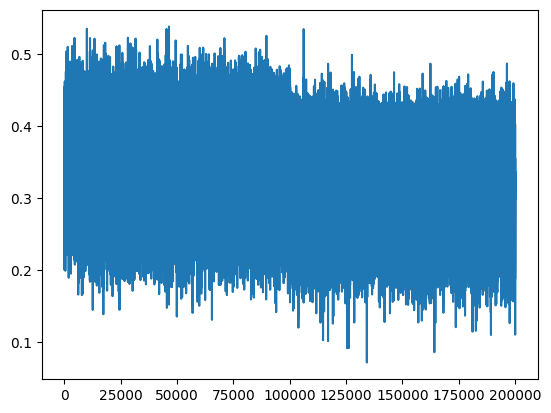

In [19]:
plt.plot(lossi)
plt.show()

In [ ]:
max_steps = 200000

batch_size = 32
lossi_ = []

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # for stability
    return exp_logits/np.sum(exp_logits, axis = 1, keepdims=True)

def cross_entropy(logits, targets):
    probs = softmax(logits)
    log_probs = -np.log(probs[np.arange(len(targets)), targets])
    return np.mean(log_probs)

def forward(Xb, Yb, C, W1, b1, W2, b2):
    emb = C[Xb]                           # (B, block_size, n_embd)
    embcat = emb.reshape((emb.shape[0], -1))     # (B, block_size * n_embd)
    hpreact = embcat @ W1 + b1                   # (B, n_hidden)
    h = np.tanh(hpreact)                         # (B, n_hidden)
    logits = h @ W2 + b2                         # (B, vocab_size)
    loss = cross_entropy(logits, Yb)
    return loss


loss_grad = grad(forward, argnum=(2, 3, 4, 5, 6))  # gradients w.r.t. C, W1, b1, W2, b2


for i in range(max_steps):
    # Random batch of indices
    ix_ = np.random.choice(len(Xtr_), size=batch_size, replace=False)
    Xb_, Yb_ = Xtr_[ix], Ytr_[ix_]

    # Forward and backward pass
    loss = forward(Xb_, Yb_, C_, W1_, b1_, W2_, b2_)
    gC, gW1, gb1, gW2, gb2 = loss_grad(Xb_, Yb_, C_, W1_, b1_, W2_, b2_)

    # Update
    lr = 0.1 if i < 100000 else 0.01
    C_  -= lr * gC
    W1_ -= lr * gW1
    b1_ -= lr * gb1
    W2_ -= lr * gW2
    b2_ -= lr * gb2

    # Stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss:.4f}')
    lossi_.append(np.log10(loss))

      0/ 200000: 26.3810
  10000/ 200000: 3.0076
  20000/ 200000: 2.7372
  30000/ 200000: 2.9754
  40000/ 200000: 2.9455
